EnbPI Bootstrap Steps:
1) Extract and Clean Data
2) Preprocess Data
3) Bootstrap Synthetic Data
4) Train Bootstrap Models
5) LOO Predict and Mean Aggregate
6) Get Conformal Prediction Interval 
7) Get Coverage Rate on Test
8) Output Results

In [1]:
import numpy as np
import pandas as pd
from numpy.random import default_rng
from typing import Optional

from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from scipy import stats
from statsmodels.tsa.seasonal import STL
from scipy.special import boxcox, inv_boxcox
from sklearn.preprocessing import PowerTransformer

In [2]:
# Helper functions

# Step 1) Extract and Clean Data
def read_data(data_name, max_data_size):
    data_dir = "./Data"

    if data_name == "Solar_Atl":
        """
        4 (Alternative). NREL Solar data at Atlanta Downtown in 2018.
            - 24 observations per day and separately equally by 1H @ half an hour mark everytime
        Data descriptions see Solar Writeup
        Data download:
        (With API) https://nsrdb.nrel.gov/data-sets/api-instructions.html
        (Manual) https://maps.nrel.gov/nsrdb-viewer
        Properties:
            - Type: multivariate (5 temporal columns, 7 feature columns, 1 target)
            - Length: 8760
            - Period: entire 2018
            - Frequency: hourly (at every 30-min mark)
        """
        file_name = f"{data_name}_data.csv"
        data_df = pd.read_csv(file_name, skiprows=2)
        # data_df.shape  # 8760, 14
        data_df.drop(columns=data_df.columns[0:5], inplace=True)  # remove 5 temporal columns
        data_df.drop(columns="Unnamed: 13", inplace=True)
        # data_df.shape  # 8760, 8
        target_column = "DHI"

    elif data_name in _get_cali_cities():  # "Palo_Alto"
        """
        Properties:
            - Type: multivariate (1 datetime index, 5 temporal columns, 7 feature columns, 1 target)
            - Length: 8760
            - Period: entire 2018
            - Frequency: hourly
        """
        file_name = f"{data_name}_data.csv"
        data_df = pd.read_csv(file_name)
        data_df.drop(columns=data_df.columns[0:6], inplace=True)  # remove datetime index and 5 temporal columns
        target_column = "DHI"

    elif data_name == "appliances":
        """
        2. Appliances energy prediction Data Set
        The data set is at 10 min for about 4.5 months.
        The column named 'Appliances' is the response. Other columns are predictors
        https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction
        Properties:
            - Type: multivariate (1 temporal column, 27 feature columns, 1 target)
            - Length: 19735
            - Period: 2016-01-11 @5PM to 2016-05-27 @6PM
            - Frequency: every 10-min
        """
        file_name = f"{data_name}_data.csv"
        data_df = pd.read_csv(file_name, delimiter=",")
        # data_df.shape  # (19736, 29)
        data_df.drop("date", inplace=True, axis=1)  # remove the temporal column
        data_df.loc[:, data_df.columns != "Appliances"]
        target_column = "Appliances"

    elif data_name == "green_house":
        """
        All datasets are Multivariate time-series. They have respective Github for more details as well.
        1. Greenhouse Gas Observing Network Data Set
        Time from 5.10-7.31, 2010, with 4 samples everyday, 6 hours apart between data poits.
        Goal is to "use inverse methods to determine the optimal values of the weights in the weighted sum of 15 tracers that best matches the synthetic observations"
        In other words, find weights so that first 15 tracers will be as close to the last as possible.
        Note, data at many other grid cells are available. Others are in Downloads/🌟AISTATS Data/Greenhouse Data
        https://archive.ics.uci.edu/ml/datasets/Greenhouse+Gas+Observing+Network
        Properties:
            - Type: multivariate (15 feature columns aka tracers(?), 1 target)
            - Length: 327
            - Period: 2010-05-10 to 2010-07-31
            - Frequency: every 6-hours
        """
        file_name = f"{data_name}_data.csv"
        data_df = pd.read_csv(file_name, header=None, sep=" ").T
        # data_df.shape  # 327, 16 Note, rows are 16 time series (first 15 from tracers, last from synthetic).
        target_column = 15

    elif data_name == "Beijing_air":
        """
        3. Beijing Multi-Site Air-Quality Data Data Set
        This data set includes hourly air pollutants data from 12 nationally-controlled air-quality monitoring sites.
        Time period from 3.1, 2013 to 2.28, 2017.
        PM2.5 or PM10 would be the response.
        https://archive.ics.uci.edu/ml/datasets/Beijing+Multi-Site+Air-Quality+Data
        Properties:
            - Type: multivariate (1 index, 4 temporal columns, 12 feature columns, 1 target)
            - Length: 35064
            - Period: 2013-03-01 to 2017-02-28
            - Frequency: hourly
        """
        file_name = f"{data_name}_Tiantan_data.csv"
        data_df = pd.read_csv(file_name)
        # data_df.shape  # 35064, 18
        data_df.drop(
            columns=["No", "year", "month", "day", "hour", "wd", "station"],
            inplace=True,
            axis=1,
        )
        data_df.dropna(inplace=True)
        # data_df.shape  # 32907, 11
        target_column = "PM2.5"

    else:
        raise ValueError("data_name not found")   


    # pick maximum of X data points (for speed)
    data_df = data_df.iloc[: min(max_data_size, data_df.shape[0]), :]
    # shift target column back by one (for single-step forecast)
    data_df[target_column] = data_df[target_column].shift(-1)
    # remove final row as it does not contain target column value anymore
    data_df = data_df.iloc[:-1 , :]        

    return data_df, target_column


def _get_cali_cities():
    cali_cities = [
        "Fremont",
        "Milpitas",
        "Mountain_View",
        "North_San_Jose",
        "Palo_Alto",
        "Redwood_City",
        "San_Mateo",
        "Santa_Clara",
        "Sunnyvale",
    ]
    return cali_cities


# Step 2) this is the AR-transformer. can replace with something from sktime.  ################
def one_dimen_transform(y_train, y_test, n_lags):
    n = len(y_train)
    n1 = len(y_test)
    X_train = np.zeros((n - n_lags, n_lags))  # from n_lags+1,...,n
    X_test = np.zeros((n1, n_lags))  # from n-n_lags,...,n+n1-n_lags
    for i in range(n - n_lags):
        X_train[i, :] = y_train[i : i + n_lags]
    for i in range(n1):
        if i < n_lags:
            X_test[i, :] = np.r_[y_train[n - n_lags + i :], y_test[:i]]
        else:
            X_test[i, :] = y_test[i - n_lags : i]
    y_train = y_train[n_lags:]
    return [X_train, X_test, y_train, y_test]


# Step 3) ################
def generate_bootstrap_samples(n, m, B, bootstrap_type, block_length, random_seed):
    samples_idx = np.zeros((B, m), dtype=int)

    for b in range(B):
        if bootstrap_type == "random":  # RB
            np.random.seed(b + random_seed)
            sample_idx = np.random.choice(a=n, size=m, replace=True)
        elif bootstrap_type == "nonoverlapping":  # NBB
            sample_idx = _id_nbb_bootstrap(
                n_obs=n, block_length=block_length, random_seed=b + random_seed,
            )
        elif bootstrap_type == "moving":  # MBB
            sample_idx = _id_mbb_bootstrap(
                n_obs=n, block_length=block_length, random_seed=b + random_seed,
            )
        elif bootstrap_type == "circular":  # CBB
            sample_idx = _id_cbb_bootstrap(
                n_obs=n, block_length=block_length, random_seed=b + random_seed,
            )
        elif bootstrap_type == "stationary":  # SBB
            sample_idx = _id_sbb_bootstrap(
                n_obs=n, block_length=block_length, random_seed=b + random_seed,
            )
        else:
            raise ValueError("boostrap_type not supported")      
        samples_idx[b, :] = sample_idx

    return samples_idx


# Non-overlapping block bootstrap (NBB)
def _id_nbb_bootstrap(
    n_obs: int, block_length: int, random_seed: Optional[int] = 10
) -> np.ndarray:
    """Create bootstrapped indexes with the none overlapping block bootstrap
    ('nbb') strategy given the number of observations in a timeseries and
    the length of the blocks.
    Returns
    -------
    _id : array
        Bootstrapped indexes.
    """
    rng = default_rng(random_seed)
    
    n_blocks = int(np.ceil(n_obs / block_length))
    nexts = np.repeat([np.arange(0, block_length)], n_blocks, axis=0)
    
    blocks = rng.permutation(x=np.arange(0, n_obs, block_length)).reshape(-1, 1)
    _id = (blocks + nexts).ravel()[:n_obs]

    return _id


# Moving block bootstrap (MBB)
def _id_mbb_bootstrap(
    n_obs: int, block_length: int, random_seed: Optional[int]=10
) -> np.ndarray:
    """Create bootstrapped indexes with the moving block bootstrap
    ('mbb') strategy given the number of observations in a timeseries
    and the length of the blocks.
    Returns
    -------
    _id : array
        Bootstrapped indexes.
    """
    rng = default_rng(random_seed)
    try:
        rng_integers = rng.integers
    except AttributeError:
        rng_integers = rng.randint

    n_blocks = int(np.ceil(n_obs / block_length))
    nexts = np.repeat([np.arange(0, block_length)], n_blocks, axis=0)
    
    last_block = n_obs - block_length
    blocks = rng_integers(low=0, high=last_block, size=(n_blocks, 1), dtype=int)
    _id = (blocks + nexts).ravel()[:n_obs]

    return _id


# Circular block bootstrap (MBB)
def _id_cbb_bootstrap(
    n_obs: int, block_length: int, random_seed: Optional[int]=10
) -> np.ndarray:
    """Create bootstrapped indexes with the circular block bootstrap
    ('cbb') strategy given the number of observations in a timeseries
    and the length of the blocks.
    Returns
    -------
    _id : array
        Bootstrapped indexes.
    """
    rng = default_rng(random_seed)
    try:
        rng_integers = rng.integers
    except AttributeError:
        rng_integers = rng.randint

    n_blocks = int(np.ceil(n_obs / block_length))
    nexts = np.repeat([np.arange(0, block_length)], n_blocks, axis=0)
    
    last_block = n_obs
    blocks = rng_integers(low=0, high=last_block, size=(n_blocks, 1), dtype=int)
    _id = np.mod((blocks + nexts).ravel(), n_obs)[:n_obs]

    return _id


# Stationary block bootstrap (SBB)
def _id_sbb_bootstrap(
    n_obs: int, block_length: int, random_seed: Optional[int]=10
) -> np.ndarray:
    """Create bootstrapped indexes with the stationary block bootstrap
    ('sb') strategy given the number of observations in a timeseries
    and the length of the blocks.
    Returns
    -------
    _id : array
        Bootstrapped indexes.
    """
    rng = default_rng(random_seed)
    try:
        rng_integers = rng.integers
    except AttributeError:
        rng_integers = rng.randint
    #
    rng_poisson = rng.poisson
    #
    random_block_length = rng_poisson(lam=block_length, size=n_obs)
    random_block_length[random_block_length < 3] = 3
    random_block_length[random_block_length >= n_obs] = n_obs
    random_block_length = random_block_length[random_block_length.cumsum() <= n_obs]
    residual_block = n_obs - random_block_length.sum()
    if residual_block > 0:
        random_block_length = np.append(random_block_length, residual_block)
    #
    n_blocks = random_block_length.shape[0]
    nexts = np.zeros((n_blocks, random_block_length.max() + 1))
    nexts[np.arange(n_blocks), random_block_length] = 1
    nexts = np.flip(nexts, 1).cumsum(1).cumsum(1).ravel()
    nexts = (nexts[nexts > 1] - 2).astype(int)
    #
    last_block = n_obs - random_block_length.max()
    blocks = np.zeros(n_obs, dtype=int)
    if last_block > 0:
        blocks = rng_integers(low=0, high=last_block, size=n_blocks)
        blocks = np.repeat(blocks, random_block_length)
    _id = blocks + nexts
    #
    return _id


# Step 4) ################
def initiate_regressor(model_type):
    min_alpha = 0.0001
    max_alpha = 10

    if model_type == "lasso":
        model = LassoCV(alphas=np.linspace(min_alpha, max_alpha, 10))
    elif model_type == "ridge":
        model = RidgeCV(alphas=np.linspace(min_alpha, max_alpha, 10))
    elif model_type == "random_forest":
        model = RandomForestRegressor(
            n_estimators=10,
            criterion="squared_error",
            bootstrap=False,
            max_depth=2,
            n_jobs=-1,
        )
    elif model_type == "extra_trees":
        model = ExtraTreesRegressor(
            n_estimators=10,
            criterion="squared_error",
            bootstrap=False,
            max_depth=2,
            n_jobs=-1
        )
    else:
        raise ValueError("model_type not supported")

    return model

In [3]:
#Transformation function
def transform(data, type_="yeojohnson"):
    if type_=="yeojohnson":
        xt, lmbda = stats.yeojohnson(data)
    elif type_=="boxcox":
        xt, lmbda = stats.boxcox(data)
    return xt, lmbda

#Decomposing Seasonal and trend components
def decompose(data, type_="stl"):
    if type_=="stl":
        stl_model=STL(data, period=24, seasonal=13)
        res=stl_model.fit()
        seasonal=res.seasonal
        trend=res.trend
        residual=res.resid
    return seasonal, trend, residual

#Restore Seasonal and trend components
def restore(residual, seasonal, trend, type_="add"):
    if type_=="add":
        yt=residual+seasonal+trend
    return yt

#Inverse Transform Yeojohnson Function
def invert_yeojhonson(value, lmbda):
    if value>= 0 and lmbda == 0:
        return exp(value) - 1
    elif value >= 0 and lmbda != 0:
        return (value * lmbda + 1) ** (1 / lmbda) - 1
    elif value < 0 and lmbda != 2:
        return 1 - (-(2 - lmbda) * value + 1) ** (1 / (2 - lmbda))
    elif value < 0 and lmbda == 2:
        return 1 - exp(-value)

#Inverse Transform Function (in general)
def inverse_transform(data, lmbda, type_="yeojohnson"):
    if type_=="yeojohnson":
        inverted = [invert_yeojhonson(x, lmbda) for x in data]
        inverted_array=np.array(inverted)
    elif type_=="boxcox":
        inverted_array=inv_boxcox(data, lmbda)
    return inverted_array

In [4]:
# Main executable function

def enbpi_exec(
    data_list,
    max_data_size,
    method,
    train_fractions,
    B_list,
    bootstrap_types,
    block_lengths,
    model_types,
    alphas,
    itrial=0,
    one_dim_list=[False],
    n_lags=1,
    output_name = "many_data",
    verbose=1,
):

    # Step 1) Extract and Clean Data
    for data_name in data_list:
        if verbose >= 1: 
            print("\n\n" + "="*80)
            print(f"data_name='{data_name}'")
        data_df, target_column = read_data(data_name, max_data_size)
        tab_str = "- "
        if verbose == 2:
            print(f"{tab_str}data_name shape:{data_df.shape}")
            print(f"{tab_str}target_column='{target_column}'")

        # STEP 2): Preprocess Data ################    
        for one_dim in one_dim_list:
            if verbose >= 1: print(f"\n{tab_str}one_dim={one_dim}")
            # Separate results output for one_dim True and False
            results_df = pd.DataFrame()
            # results_df = pd.DataFrame(columns=_get_results_columns())
            for train_fraction in train_fractions:
                tab_str = "  " + tab_str
                if verbose >= 1: print(f"\n{tab_str}train_fraction={train_fraction}")
                # 2a) Split train/test sets
                # get X and y data
                data_X = data_df.drop(target_column, axis=1)
                data_y = data_df[target_column]
                # convert X and y data to numpy
                data_X_numpy = data_X.to_numpy()
                data_y_numpy = data_y.to_numpy()
                # get train idx to split train and test
                train_size = int(len(data_df) * train_fraction)
                # split into 4
                X_train_numpy = data_X_numpy[:train_size, :]
                X_test_numpy = data_X_numpy[train_size:, :]
                y_train_numpy = data_y_numpy[:train_size]
                y_test_numpy = data_y_numpy[train_size:]
                # 2b) Get AR coeffs (optional)
                if one_dim:
                    X_train, X_test, y_train, y_test = one_dimen_transform(
                        y_train_numpy,
                        y_test_numpy,
                        n_lags=n_lags,  # d
                    )
                else:
                    X_train = X_train_numpy.copy()
                    X_test = X_test_numpy.copy()
                    y_train = y_train_numpy.copy()
                    y_test = y_test_numpy.copy()
                tab_str = "  " + tab_str
                if verbose == 2: 
                    print(f"{tab_str}X_train shape: {X_train.shape}")
                    print(f"{tab_str}X_test shape: {X_test.shape}")
                    print(f"{tab_str}y_train shape: {y_train.shape}")
                    print(f"{tab_str}y_test shape: {y_test.shape}")

                # STEP 3) Bootstrap Synthetic Data ################
                for B in B_list:
                    for bootstrap_type in bootstrap_types:
                        for block_length in block_lengths:
                            if verbose >= 1:
                                print(f"{tab_str}B={B}, bootstrap_type='{bootstrap_type}', block_length={block_length}")
                            n = len(X_train)
                            n1 = len(X_test)
                            m = n
                            # tot_trial = 1    # For CP method that randomizes (for EnbPI, should be set to 1)
                            itrial = itrial  # for tot_trial in range(tot_trial)
                            random_seed = B + itrial
                            boot_samples_idx = generate_bootstrap_samples(
                                n=n,
                                m=m,
                                B=B,
                                bootstrap_type=bootstrap_type,
                                block_length=block_length,
                                random_seed=random_seed,
                            )
                            tab_str = "  " + tab_str
                            if verbose == 2: print(f"{tab_str}Bootstrap samples indexes shape: {boot_samples_idx.shape}")
                            # print(boot_samples_idx)

                            # STEP 4) Train Bootstrapped Models ################
                            # tab_str = "  " + tab_str    
                            for model_type in model_types:
                                # if verbose >= 1: print(f"{tab_str}model_type='{model_type}'")
                                # hold predictions from each f^b
                                boot_predictions = np.zeros((B, (n + n1)), dtype=float)
                                # for i^th column, it shows which f^b uses i in training (so exclude in aggregation)
                                in_boot_sample = np.zeros((B, n), dtype=bool)
                                for b in range(B):
                                    X_train_boot = X_train[boot_samples_idx[b], :]
                                    y_train_boot = y_train[boot_samples_idx[b],]
                                    model = initiate_regressor(model_type)
                                    model.fit(
                                        X_train_boot,
                                        y_train_boot,
                                        # epochs=10,
                                        # batch_size=bsize,
                                        # callbacks=[callback],
                                        # verbose=0,
                                    )
                                    # Model's prediction for every observation on every bootstrapped data
                                    boot_predictions[b] = model.predict(np.r_[X_train, X_test]).flatten()
                                    # Whether a observation in the training data is sampled for the given bootstrapped data
                                    # If it is true, then this observation should NOT be used for model prediction
                                    in_boot_sample[b, boot_samples_idx[b]] = True
                                tab_str = "  " + tab_str
                                if verbose == 2:
                                    print(f"{tab_str}boot_predictions shape: {boot_predictions.shape}")
                                    print(f"{tab_str}in_boot_sample shape: {in_boot_sample.shape}")

                                # STEP 5) LOO Predict and Mean Aggregate
                                y_in_pred = np.zeros(n)          # Mean aggregated predict on in-sample train set
                                y_LOO_preds = np.zeros((n, n1))  # Non-aggregated predict on OOS test set
                                y_pred = np.zeros(n1)            # Aggregated predict on OOS test set

                                ensemble_online_resid = np.array([])    # LOO scores
                                # LOO in-sample train predict and OOS test predict 
                                for i in range(n):
                                    b_keep = np.argwhere(~(in_boot_sample[:, i])).reshape(-1)
                                    if len(b_keep) > 0:
                                        # Get the LOO predictions for i for both in-sample and OOS
                                        y_train_LOO_boot_preds = boot_predictions[b_keep, i]
                                        y_in_pred[i] = y_train_LOO_boot_preds.mean()  # Mean aggregate to form a scalar value
                                        y_LOO_boot_preds = boot_predictions[b_keep, n:]
                                        y_LOO_preds[i] = y_LOO_boot_preds.mean(0)
                                    else:  # if aggregating an empty set of models, predict zero everywhere
                                        if verbose == 2: print(f"{tab_str}  WARNING: no bootstrapped models available for i={i}")
                                y_pred = y_LOO_preds.mean(0)
                                if verbose == 2:
                                    print(f"{tab_str}y_in_pred shape: {y_in_pred.shape}")
                                    print(f"{tab_str}y_pred shape: {y_pred.shape}")
                                    print(f"{tab_str}  y_LOO_preds shape: {y_LOO_preds.shape}")

                                # STEP 6) Aggregate Model with LOO
                                for alpha in alphas:
                                    # if verbose >= 1: print(f"{tab_str}alpha={alpha}")
                                    # Get absolute residual and sort
                                    abs_resid = np.abs(np.subtract(y_train, y_in_pred))
                                    abs_resid.sort()
                                    # Get q-hat value
                                    q_idx = int(-len(abs_resid)*alpha)
                                    q_hat = abs_resid[q_idx]
                                    # Evaluation metric 1: PI width
                                    width = round(q_hat*2, 6)
                                    tab_str = "  " + tab_str
                                    if verbose == 2: print(f"{tab_str}width={width}")

                                    # STEP 7) Get Coverage Rate from Test
                                    # Get OOS absolute residual and sort
                                    oos_abs_resid = np.abs(np.subtract(y_test, y_pred))
                                    oos_abs_resid.sort()
                                    # Count number of residuals below or equal to q_hat, or within the interval width.
                                    n_coverage = np.asarray(oos_abs_resid <= q_hat).sum()
                                    # Evaluation metric 2: Coverage rate
                                    coverage = round(n_coverage/n1, 6)
                                    if verbose == 2: print(f"{tab_str}coverage={coverage}")
                                    """
                                    NOTE: I am using the symmetical conformal prediction (like in NP), instead of the
                                          fancy method that Chen did. That is why the coverage rate is near the 
                                          theroretical guarantee limit of 2*alpha.
                                    """

                                    #### STEP 8) Output Results
                                    results_row = {
                                        "data_name": data_name,
                                        "one_dim": one_dim,
                                        "itrial": itrial,
                                        "train_fraction": train_fraction,
                                        "B": B,
                                        "bootstrap_type": bootstrap_type,
                                        "block_length": block_length,
                                        "model_type": model.__class__.__name__,  # "muh_fun"
                                        "method": method,
                                        "alpha": alpha,
                                        "width": width,    
                                        "coverage": coverage,
                                    }
                                    results_df = pd.concat([results_df, pd.DataFrame([results_row])], ignore_index=True)

                                    tab_str = tab_str[2:]
                                tab_str = tab_str[2:]
                            tab_str = tab_str[2:]
                tab_str = tab_str[4:]

    results_df.to_csv(f'Results/{output_name}_many_alpha_many_train_revamp.csv', index=False)

# Test Code (ignore)

In [4]:
pd.read_csv('Solar_Atl_data.csv', skiprows=1, header=1)

,Year,Month,Day,Hour,Minute,DHI,DNI,Dew Point,Surface Albedo,Wind Speed,Relative Humidity,Temperature,Pressure,Unnamed: 13
0,2018,1,1,0,30,0,0,-12.3,0.11,1.9,59.45,-5.7,989,NaN
1,2018,1,1,1,30,0,0,-12.6,0.11,1.8,59.64,-6.0,989,NaN
2,2018,1,1,2,30,0,0,-12.7,0.11,1.8,60.25,-6.2,990,NaN
3,2018,1,1,3,30,0,0,-12.8,0.11,1.9,60.54,-6.4,990,NaN
4,2018,1,1,4,30,0,0,-13.2,0.11,1.9,60.17,-6.8,991,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2018,12,31,19,30,0,0,-7.3,0.11,1.0,73.64,-3.3,987,NaN
8756,2018,12,31,20,30,0,0,-8.3,0.11,1.5,71.91,-4.0,987,NaN
8757,2018,12,31,21,30,0,0,-9.9,0.11,1.8,66.29,-4.6,987,NaN
8758,2018,12,31,22,30,0,0,-11.0,0.11,1.8,63.41,-5.1,988,NaN


We can see that the data is within 12 months, and the frequency is hour

In [3]:
df_atl, target_solar=read_data('Solar_Atl', 10000)

In [5]:
train_size=int(len(df_atl)*0.8001) #set train fraction to be 0.8001 to avoid out of index for NBB (case specific)
train_size

7008

In [6]:
df_atl

,DHI,DNI,Dew Point,Surface Albedo,Wind Speed,Relative Humidity,Temperature,Pressure
0,0.0,0,-12.3,0.11,1.9,59.45,-5.7,989
1,0.0,0,-12.6,0.11,1.8,59.64,-6.0,989
2,0.0,0,-12.7,0.11,1.8,60.25,-6.2,990
3,0.0,0,-12.8,0.11,1.9,60.54,-6.4,990
4,0.0,0,-13.2,0.11,1.9,60.17,-6.8,991
...,...,...,...,...,...,...,...,...
8754,0.0,0,17.7,0.13,2.4,95.70,18.4,979
8755,0.0,0,-7.3,0.11,1.0,73.64,-3.3,987
8756,0.0,0,-8.3,0.11,1.5,71.91,-4.0,987
8757,0.0,0,-9.9,0.11,1.8,66.29,-4.6,987


In [7]:
df_atl.to_numpy()

array([[  0.  ,   0.  , -12.3 , ...,  59.45,  -5.7 , 989.  ],
       [  0.  ,   0.  , -12.6 , ...,  59.64,  -6.  , 989.  ],
       [  0.  ,   0.  , -12.7 , ...,  60.25,  -6.2 , 990.  ],
       ...,
       [  0.  ,   0.  ,  -8.3 , ...,  71.91,  -4.  , 987.  ],
       [  0.  ,   0.  ,  -9.9 , ...,  66.29,  -4.6 , 987.  ],
       [  0.  ,   0.  , -11.  , ...,  63.41,  -5.1 , 988.  ]])

In [8]:
df_atl.iloc[:train_size, :]

,DHI,DNI,Dew Point,Surface Albedo,Wind Speed,Relative Humidity,Temperature,Pressure
0,0.0,0,-12.3,0.11,1.9,59.45,-5.7,989
1,0.0,0,-12.6,0.11,1.8,59.64,-6.0,989
2,0.0,0,-12.7,0.11,1.8,60.25,-6.2,990
3,0.0,0,-12.8,0.11,1.9,60.54,-6.4,990
4,0.0,0,-13.2,0.11,1.9,60.17,-6.8,991
...,...,...,...,...,...,...,...,...
7003,0.0,0,16.9,0.13,0.6,100.00,16.9,983
7004,0.0,0,16.8,0.13,0.6,100.00,16.8,983
7005,0.0,0,16.9,0.13,0.6,100.00,16.9,982
7006,0.0,0,17.0,0.13,0.6,100.00,17.0,982


In [9]:
df_atl.iloc[[0,2,4],:]

,DHI,DNI,Dew Point,Surface Albedo,Wind Speed,Relative Humidity,Temperature,Pressure
0,0.0,0,-12.3,0.11,1.9,59.45,-5.7,989
2,0.0,0,-12.7,0.11,1.8,60.25,-6.2,990
4,0.0,0,-13.2,0.11,1.9,60.17,-6.8,991


In [10]:
df_atl['DHI'][:train_size]

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
7003    0.0
7004    0.0
7005    0.0
7006    0.0
7007    0.0
Name: DHI, Length: 7008, dtype: float64

In [19]:
df_atl['DHI'][0:10]

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
5      0.0
6      0.0
7     18.0
8     45.0
9    103.0
Name: DHI, dtype: float64

In [17]:
stl_model=STL(df_atl['DHI'], period=24)

In [18]:
res=stl_model.fit()
seasonal=res.seasonal
trend=res.trend
residual=res.resid

In [20]:
residual

0      -6.566020
1      -6.523877
2      -6.460035
3      -6.372931
4      -6.261930
          ...   
8754   -1.743772
8755   -1.985177
8756   -2.231510
8757   -2.478863
8758   -2.723221
Name: resid, Length: 8759, dtype: float64

In [22]:
#transforming target column
xt, lmbda=transform(df_atl['DHI'])

In [23]:
xt

array([-0., -0., -0., ..., -0., -0., -0.])

Matplotlib is building the font cache; this may take a moment.


Text(0.5, 1.0, 'Probplot after Yeo-Johnson transformation')

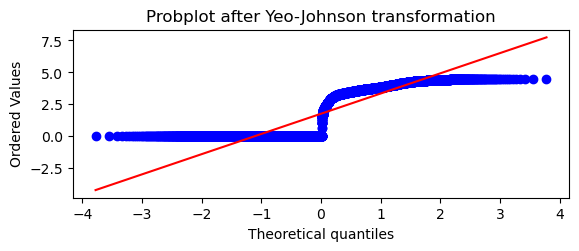

In [24]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax2 = fig.add_subplot(212)
prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after Yeo-Johnson transformation')

In [28]:
inverse_transform(xt, lmbda=lmbda, type_="yeojohnson")

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
8754    0.0
8755    0.0
8756    0.0
8757    0.0
8758    0.0
Length: 8759, dtype: float64

In [33]:
inv_boxcox(xt, lmbda)

array([1., 1., 1., ..., 1., 1., 1.])

In [31]:
yt, lmbda=stats.boxcox(df_atl['DHI'])

ValueError: Data must be positive.

# Testing with boxcox

In [38]:
sum(df_atl['Relative Humidity']<=0)

0

In [39]:
yt, lmbda=stats.boxcox(df_atl['Relative Humidity'])

In [40]:
yt

array([ 8341.27543703,  8406.13388559,  8616.36349894, ...,
       13238.08359301, 10865.22635776,  9754.69962686])

In [41]:
lmbda

2.4272865602828544

In [42]:
stl_model=STL(yt, period=24, seasonal=7)

In [43]:
res=stl_model.fit()
seasonal=res.seasonal
trend=res.trend
residual=res.resid

In [44]:
n=len(yt)
m=n
B=10
block_length=12
boot_samples_idx = generate_bootstrap_samples(
                                n=n,
                                m=m,
                                B=B,
                                bootstrap_type='moving',
                                block_length=block_length,
                                random_seed=1,
                            )

In [45]:
boot_samples_idx

array([[4138, 4139, 4140, ..., 8090, 8091, 8092],
       [7326, 7327, 7328, ..., 5658, 5659, 5660],
       [7098, 7099, 7100, ..., 2389, 2390, 2391],
       ...,
       [6293, 6294, 6295, ..., 4325, 4326, 4327],
       [3687, 3688, 3689, ..., 4124, 4125, 4126],
       [6792, 6793, 6794, ..., 4985, 4986, 4987]])

In [54]:
y_restored=residual[boot_samples_idx[0]]+seasonal+trend

In [58]:
inv_boxcox(y_restored, lmbda)

array([57.74035493, 53.93554011, 52.12679136, ..., 77.20465696,
       75.15877652, 77.38318343])

In [57]:
sum(inv_boxcox(y_restored, lmbda)==np.nan)

0

# Testing with yeo-johnson

In [ ]:
pt = PowerTransformer()
pt.fit(np.array(df_atl['DHI']).reshape(-1,1))

In [13]:
pt.lambdas_

array([-0.10876401])

In [16]:
yt=pt.transform(np.array(df_atl['DHI']).reshape(-1,1))

In [18]:
pt.inverse_transform(yt)[0:10]

array([[  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [ 18.],
       [ 45.],
       [103.]])

In [20]:
yt

array([[-0.96172039],
       [-0.96172039],
       [-0.96172039],
       ...,
       [-0.96172039],
       [-0.96172039],
       [-0.96172039]])

In [ ]:
stl_model=STL(yt, period=24, seasonal=7)

# Test Code cont.

In [32]:
df_atl['DHI']

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
8754    0.0
8755    0.0
8756    0.0
8757    0.0
8758    0.0
Name: DHI, Length: 8759, dtype: float64

In [10]:
df_atl['DHI'].head(10)

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
5      0.0
6      0.0
7     18.0
8     45.0
9    103.0
Name: DHI, dtype: float64

In [19]:
seasonal, trend, residual=decompose(xt, "stl")

In [21]:
residual[[0,2,4]]

array([-1.65435163, -1.45638041, -1.20522564])

In [13]:
(seasonal+trend+residual)[0:10]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 2.51950754, 3.13151081, 3.64624715])

In [16]:
xt[0:10]

array([-0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        ,  2.51950754,  3.13151081,  3.64624715])

In [20]:
#transforming X variables
df_atl.dtypes

DHI                  float64
DNI                    int64
Dew Point            float64
Surface Albedo       float64
Wind Speed           float64
Relative Humidity    float64
Temperature          float64
Pressure               int64
dtype: object

In [13]:
#Tranform X variables
cols=df_atl.columns
lmbda_dict={}
xt_dict={}
for col in cols:
    xt, lmbda=transform(df_atl[col])
    lmbda_dict.update({col:lmbda})
    xt_dict.update({col:xt})
print(xt_dict)
print(lmbda_dict)

{'DHI': array([-0., -0., -0., ..., -0., -0., -0.]), 'DNI': array([-0., -0., -0., ..., -0., -0., -0.]), 'Dew Point': array([-9.68884549, -9.9001603 , -9.97045833, ..., -6.80204113,
       -7.97361771, -8.7654859 ]), 'Surface Albedo': array([0.04183325, 0.04183325, 0.04183325, ..., 0.04183325, 0.04183325,
       0.04183325]), 'Wind Speed': array([0.59316849, 0.58350457, 0.58350457, ..., 0.54928272, 0.58350457,
       0.58350457]), 'Relative Humidity': array([ 9613.9910649 ,  9688.34159805,  9929.34422527, ...,
       15230.2461812 , 12508.01256889, 11234.47295806]), 'Temperature': array([-5.59739883, -5.88902064, -6.08333248, ..., -3.94094633,
       -4.52640066, -5.01356902]), 'Pressure': array([5.08752261e+20, 5.08752261e+20, 5.12463049e+20, ...,
       5.01400045e+20, 5.01400045e+20, 5.05064633e+20])}
{'DHI': -0.10876401428078447, 'DNI': -0.26358177669201527, 'Dew Point': 1.1348362526458553, 'Surface Albedo': -21.32140100308805, 'Wind Speed': -1.2315463054082285, 'Relative Humidity': 

In [14]:
xt_dict['DHI']

array([-0., -0., -0., ..., -0., -0., -0.])

In [15]:
df_atl_t=pd.DataFrame(xt_dict)
df_atl_t

,DHI,DNI,Dew Point,Surface Albedo,Wind Speed,Relative Humidity,Temperature,Pressure
0,-0.0,-0.0,-9.688845,0.041833,0.593168,9613.991065,-5.597399,5.087523e+20
1,-0.0,-0.0,-9.900160,0.041833,0.583505,9688.341598,-5.889021,5.087523e+20
2,-0.0,-0.0,-9.970458,0.041833,0.583505,9929.344225,-6.083332,5.124630e+20
3,-0.0,-0.0,-10.040687,0.041833,0.593168,10045.151786,-6.277565,5.124630e+20
4,-0.0,-0.0,-10.320922,0.041833,0.593168,9897.537278,-6.665800,5.161971e+20
...,...,...,...,...,...,...,...,...
8754,-0.0,-0.0,23.575567,0.043438,0.632097,30462.484210,18.986084,4.728984e+20
8755,-0.0,-0.0,-6.056133,0.041833,0.466194,16132.748052,-3.256595,5.014000e+20
8756,-0.0,-0.0,-6.802041,0.041833,0.549283,15230.246181,-3.940946,5.014000e+20
8757,-0.0,-0.0,-7.973618,0.041833,0.583505,12508.012569,-4.526401,5.014000e+20


In [5]:
#Tranform and decompose X variables
cols=df_atl.columns
lmbda_dict={}
xt_dict={}
season_dict={}
trend_dict={}
resid_dict={}
for col in cols:
    #Yeojohnson transform
    xt, lmbda=transform(df_atl[col])
    lmbda_dict.update({col:lmbda})
    xt_dict.update({col:xt})
    
    #STL decompose
    seasonal, trend, residual=decompose(xt, "stl")
    season_dict.update({col:seasonal})
    trend_dict.update({col:trend})
    resid_dict.update({col:residual})
print(season_dict)
print(trend_dict)
print(resid_dict)

{'DHI': array([ 0.10738584,  0.06926368, -0.17366197, ..., -0.00691508,
       -0.16183907, -0.07647602]), 'DNI': array([ 0.32770363,  0.52412491,  0.45637576, ..., -0.39085995,
        0.40626727, -0.41748419]), 'Dew Point': array([ 0.21506391,  0.10501229,  0.05332355, ..., -7.78539191,
       -7.61382644, -7.24762103]), 'Surface Albedo': array([ 4.94389807e-06, -1.52214463e-05, -3.67392669e-05, ...,
       -3.76232404e-04, -3.67939778e-04, -3.57527432e-04]), 'Wind Speed': array([-0.00341805, -0.01164926, -0.00711456, ..., -0.04289033,
       -0.01380339,  0.01272939]), 'Relative Humidity': array([ -307.23998727,  -547.01020745,  -511.98577425, ...,
       -2522.56121637, -3569.12902317, -3857.48253509]), 'Temperature': array([ 1.11193353,  1.17076638,  1.05222568, ..., -6.07938117,
       -5.86159909, -5.58671301]), 'Pressure': array([-2.70021556e+18, -4.63896883e+18, -2.99594256e+18, ...,
        9.04187660e+18,  9.51095041e+18,  9.64637107e+18])}
{'DHI': array([1.54696578, 1.58762

In [16]:
pd.DataFrame(resid_dict)

,DHI,DNI,Dew Point,Surface Albedo,Wind Speed,Relative Humidity,Temperature,Pressure
0,-1.654352,-0.562242,0.741137,-0.000016,0.002310,2234.044909,-1.350680,-8.325027e+18
1,-1.656887,-0.784729,0.649443,0.000005,0.001110,2623.006383,-1.754131,-6.541310e+18
2,-1.456380,-0.745230,0.640205,0.000027,-0.003180,2908.008701,-1.886486,-4.636874e+18
3,-1.445786,-0.883192,0.662093,0.000050,0.014370,3035.387770,-1.735412,-3.982618e+18
4,-1.205226,-0.877881,0.036399,0.000074,0.029466,2124.763434,-1.299839,-1.515594e+18
...,...,...,...,...,...,...,...,...
8754,-0.423136,-0.174085,4.493040,0.000181,0.052251,1683.195146,3.366419,-4.588783e+18
8755,-1.318249,-0.160564,-13.445556,-0.000794,-0.058999,-6209.059413,-10.260799,1.208809e+19
8756,-1.800255,-0.209283,-14.031099,-0.000785,-0.009249,-6198.466408,-10.913485,1.084445e+19
8757,-1.610230,-1.002026,-15.129014,-0.000778,-0.004334,-7715.487262,-11.531586,1.019750e+19


In [30]:
len(season_dict['DHI'])

8759

In [14]:
#restore seasonal and trend components, then inverse transform X variables
cols=df_atl.columns
#X after adding back seasonal and trend
x_restored_dict={}
#X after inverse transformation
x_original_dict={}
for col in cols:
    x_restored=resid_dict[col]+season_dict[col]+trend_dict[col]
    x_restored_dict.update({col:x_restored})
    
    x_original=inverse_transform(x_restored, lmbda_dict[col])
    x_original_dict.update({col:x_original})
print(x_restored_dict)
print(x_original_dict['DHI'][0:10])

{'DHI': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
       -2.22044605e-16,  0.00000000e+00,  0.00000000e+00]), 'DNI': array([ 0.00000000e+00,  5.55111512e-17,  0.00000000e+00, ...,
        0.00000000e+00, -1.11022302e-16,  0.00000000e+00]), 'Dew Point': array([-9.68884549, -9.9001603 , -9.97045833, ..., -6.80204113,
       -7.97361771, -8.7654859 ]), 'Surface Albedo': array([0.04183325, 0.04183325, 0.04183325, ..., 0.04183325, 0.04183325,
       0.04183325]), 'Wind Speed': array([0.59316849, 0.58350457, 0.58350457, ..., 0.54928272, 0.58350457,
       0.58350457]), 'Relative Humidity': array([ 9613.9910649 ,  9688.34159805,  9929.34422527, ...,
       15230.2461812 , 12508.01256889, 11234.47295806]), 'Temperature': array([-5.59739883, -5.88902064, -6.08333248, ..., -3.94094633,
       -4.52640066, -5.01356902]), 'Pressure': array([5.08752261e+20, 5.08752261e+20, 5.12463049e+20, ...,
       5.01400045e+20, 5.01400045e+20, 5.05064633e+20])}
[0.0, 0.0, 0.0, 0.0, 0.0, 0.

The additive model is Y[t] = T[t] + S[t] + e[t]

The multiplicative model is Y[t] = T[t] * S[t] * e[t]

# Control

In [12]:
# Params
# Step 1) params
# cali_cities = ["Palo_Alto"]
# data_list = _get_cali_cities()
# data_list = ["Solar_Atl"] + cali_cities + ["appliances", "Beijing_air"]
data_list = ["Solar_Atl"]
max_data_size = 10000

# Step 2) params
train_fractions = [0.8001]
# train_fractions = [0.1, 0.2]
# train_fractions = [0.5, 0.6, 0.7, 0.8]
# train_fractions = [0.3, 0.4, 0.5, 0.6, 0.7]  # EnbPI WP Pg. 8
# print(train_fractions)
# one_dim_list = [True]
one_dim_list = [False]
n_lags = 24  # 'n_lags' aka 'd` is num_lookbacks for AR-transformer

# Step 3) params
itrial = 0
B_list = [30]  # number of bootstraps list
# B_list = [20, 25, 30, 35, 40, 45, 50]  # EnbPI WP Pg. 11: between 20-50 is sufficient
# bootstrap_types = ["random", "moving"]  # "nonoverlapping" has problem -> IndexError: index 851 is out of bounds for axis 0 with size 851
# bootstrap_types = ["random", "moving", "circular", "stationary"]
bootstrap_types = ["random", "moving", "nonoverlapping"]
block_lengths = [6, 12, 24]
# block_lengths = [6, 12, 24, 48, 60, 72]

# Step 4) params
# model_types = ["ridge", "random_forest"]  # muh_fun
model_types = ["lasso", "ridge", "random_forest"]  # "neural_networks"
method = "Ensemble"

# Step 6) params
alphas = [0.05, 0.1, 0.15]
# alphas = [0.05, 0.1, 0.15, 0.2, 0.25]  # EnbPI WP Pg. 17: five equally spaces 1-a [0.75, 0.95] are chosen
# alphas = [0.01, 0.10, 0.20, 0.50, 0.80, 0.90, 0.99]
# alphas = [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.50, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99]

# Step 8) params
output_name = "Solar_Atl"
verbose = 1  # 0 no print statement, 1 only params, 2 everything

In [15]:
%%time
# Execute!

enbpi_exec(
    # Step 1) Extract and Clean Data
    data_list=data_list,
    max_data_size=max_data_size,
    # Step 2) Preprocess Data
    train_fractions=train_fractions,
    one_dim_list=one_dim_list,
    n_lags=n_lags,
    # Step 3) Preprocess Data
    itrial=itrial,
    B_list=B_list,
    bootstrap_types=bootstrap_types,
    block_lengths=block_lengths,
    # STEP 4) Train Bootstrapped Models
    model_types=model_types,
    method=method,
    # STEP 6) Get Conformal Prediction Interval
    alphas=alphas,
    # STEP 8) Output Results
    output_name=output_name,
    verbose=verbose,
)



data_name='Solar_Atl'

- one_dim=False

  - train_fraction=0.8001
    - B=30, bootstrap_type='random', block_length=6


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9972.80608472228, tolerance: 7832.349723956466
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24608787.918542825, tolerance: 7832.349723956466
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24392767.918236416, tolerance: 7680.166777042452
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anacon

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.955e+07, tolerance: 9.366e+03
  model = cd_fast.enet_coordinate_descent(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23981655.631489497, tolerance: 7612.423638672856
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24196093.33054986, tolerance: 7647.381283696038
  model = cd_fast.e

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.028e+07, tolerance: 9.450e+03
  model = cd_fast.enet_coordinate_descent(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23751401.44414732, tolerance: 7522.0731681769375
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23741285.330108833, tolerance: 7526.552878005709
  model = cd_fast.

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.977e+07, tolerance: 9.375e+03
  model = cd_fast.enet_coordinate_descent(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23930428.778653983, tolerance: 7464.53334607563
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24210050.36252783, tolerance: 7523.660647252941
  model = cd_fast.en

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10639.301143109798, tolerance: 7521.112506475203
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23823318.796683554, tolerance: 7521.112506475203
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12369.628009445965, tolerance: 7468.889530592231
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anac

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24806387.323539, tolerance: 7887.638091492767
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.109e+07, tolerance: 9.778e+03
  model = cd_fast.enet_coordinate_descent(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25187809.43538334, tolerance: 8018.292925954339
  model = cd_fast.enet

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.076e+07, tolerance: 9.753e+03
  model = cd_fast.enet_coordinate_descent(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23694513.57659692, tolerance: 7372.40579316804
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13301.192254886031, tolerance: 7759.686062290398
  model = cd_fast.en

    - B=30, bootstrap_type='random', block_length=12


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9972.80608472228, tolerance: 7832.349723956466
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24608787.918542825, tolerance: 7832.349723956466
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24392767.918236416, tolerance: 7680.166777042452
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anacon

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.955e+07, tolerance: 9.366e+03
  model = cd_fast.enet_coordinate_descent(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23981655.631489497, tolerance: 7612.423638672856
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24196093.33054986, tolerance: 7647.381283696038
  model = cd_fast.e

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.028e+07, tolerance: 9.450e+03
  model = cd_fast.enet_coordinate_descent(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23751401.44414732, tolerance: 7522.0731681769375
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23741285.330108833, tolerance: 7526.552878005709
  model = cd_fast.

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.977e+07, tolerance: 9.375e+03
  model = cd_fast.enet_coordinate_descent(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23930428.778653983, tolerance: 7464.53334607563
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24210050.36252783, tolerance: 7523.660647252941
  model = cd_fast.en

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.043e+07, tolerance: 9.584e+03
  model = cd_fast.enet_coordinate_descent(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24429682.82056091, tolerance: 7710.07232893329
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23715437.24169409, tolerance: 7442.520754905454
  model = cd_fast.ene

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.087e+07, tolerance: 9.672e+03
  model = cd_fast.enet_coordinate_descent(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24788675.281759024, tolerance: 7890.699840099903
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24795673.2704456, tolerance: 7873.446457170898
  model = cd_fast.en

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.079e+07, tolerance: 9.668e+03
  model = cd_fast.enet_coordinate_descent(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9718.198091320693, tolerance: 8077.150923599719
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25845385.85135562, tolerance: 8077.150923599719
  model = cd_fast.en

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.076e+07, tolerance: 9.753e+03
  model = cd_fast.enet_coordinate_descent(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23694513.57659692, tolerance: 7372.40579316804
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13301.192254886031, tolerance: 7759.686062290398
  model = cd_fast.en

    - B=30, bootstrap_type='random', block_length=24


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9972.80608472228, tolerance: 7832.349723956466
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24608787.918542825, tolerance: 7832.349723956466
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24392767.918236416, tolerance: 7680.166777042452
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anacon

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8369.112342111766, tolerance: 7548.580220210489
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23586669.89808846, tolerance: 7548.580220210489
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24042376.136700414, tolerance: 7613.018260353123
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anacon

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.951e+07, tolerance: 9.359e+03
  model = cd_fast.enet_coordinate_descent(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24570208.5014471, tolerance: 7860.32567850519
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25000193.708084438, tolerance: 7923.962653817331
  model = cd_fast.ene

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24229807.014224574, tolerance: 7505.090792759052
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23866999.593472406, tolerance: 7434.473444622779
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.028e+07, tolerance: 9.373e+03
  model = cd_

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24985600.43643316, tolerance: 7817.932406670234
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.069e+07, tolerance: 9.621e+03
  model = cd_fast.enet_coordinate_descent(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16344.241336159408, tolerance: 7385.0174290581635
  model = cd_fast.

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24771165.722122394, tolerance: 7733.989315090971
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24350192.874609448, tolerance: 7706.386374246469
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24806387.323539, tolerance: 7887.638091492767
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anacond

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.079e+07, tolerance: 9.668e+03
  model = cd_fast.enet_coordinate_descent(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9718.198091320693, tolerance: 8077.150923599719
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25845385.85135562, tolerance: 8077.150923599719
  model = cd_fast.en

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.076e+07, tolerance: 9.753e+03
  model = cd_fast.enet_coordinate_descent(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23694513.57659692, tolerance: 7372.40579316804
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13301.192254886031, tolerance: 7759.686062290398
  model = cd_fast.en

    - B=30, bootstrap_type='moving', block_length=6


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16622.3523350358, tolerance: 7772.428214056367
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23756715.926369917, tolerance: 7772.428214056367
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9201.199410617352, tolerance: 7695.109861362827
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anacond

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10336.380951926112, tolerance: 7896.617641555194
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24304724.825931836, tolerance: 7896.617641555194
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.086e+07, tolerance: 1.006e+04
  model = cd_

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24453364.93031459, tolerance: 7919.1870133428365
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25398192.16541868, tolerance: 8194.733289546924
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24211335.755825914, tolerance: 7866.839492971805
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaco

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.073e+07, tolerance: 9.744e+03
  model = cd_fast.enet_coordinate_descent(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22297238.535971537, tolerance: 7161.433710328207
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8617.742011629045, tolerance: 7333.413876507309
  model = cd_fast.e

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.949e+07, tolerance: 8.976e+03
  model = cd_fast.enet_coordinate_descent(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8207.048056788743, tolerance: 7310.151414645007
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23079102.86095187, tolerance: 7310.151414645007
  model = cd_fast.en

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.937e+07, tolerance: 9.409e+03
  model = cd_fast.enet_coordinate_descent(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24040701.782312606, tolerance: 7803.373683267932
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24391430.410476256, tolerance: 7945.253054316802
  model = cd_fast.

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22894581.045676183, tolerance: 7368.950972672132
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21567407.489215337, tolerance: 7148.804319029773
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21837635.023113646, tolerance: 7194.916187622604
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anac

    - B=30, bootstrap_type='moving', block_length=12


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22859709.505043156, tolerance: 7303.11618308954
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21897598.766877804, tolerance: 7065.584315590439
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8031.078342571855, tolerance: 7347.318083143074
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anacon

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32923.834409974515, tolerance: 7816.20055891901
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23962654.981146853, tolerance: 7816.20055891901
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14590.566914513707, tolerance: 7633.411018908308
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anacon

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28455.358332403004, tolerance: 7605.480751480547
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24200104.2768863, tolerance: 7605.480751480547
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25549.41938545555, tolerance: 7799.991023974308
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anacond

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.066e+07, tolerance: 9.629e+03
  model = cd_fast.enet_coordinate_descent(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23710922.673464414, tolerance: 7567.4607415090895
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23997383.213196825, tolerance: 7744.184919800219
  model = cd_fast

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.097e+07, tolerance: 9.787e+03
  model = cd_fast.enet_coordinate_descent(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24524511.122477297, tolerance: 7609.230907331425
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7953.954816862941, tolerance: 7030.2323653407075
  model = cd_fast.

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.119e+07, tolerance: 9.608e+03
  model = cd_fast.enet_coordinate_descent(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8717.541642561555, tolerance: 7425.773913806635
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23944342.781709608, tolerance: 7425.773913806635
  model = cd_fast.e

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22307772.829301212, tolerance: 7076.254364983941
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23074192.22205504, tolerance: 7364.829453103817
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23656239.69037282, tolerance: 7495.537833820913
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anacon

    - B=30, bootstrap_type='moving', block_length=24


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24577932.35679683, tolerance: 7833.007261862296
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24166108.68297855, tolerance: 7537.816455743842
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22975749.760890715, tolerance: 7486.025695130212
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anacon

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22039425.501725662, tolerance: 6917.331506100615
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21588763.89993211, tolerance: 7171.735361701757
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19601908.486813407, tolerance: 6980.451407098276
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaco

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.972e+07, tolerance: 9.276e+03
  model = cd_fast.enet_coordinate_descent(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22366388.5614322, tolerance: 7364.541541134508
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23873159.28035862, tolerance: 7800.356316803426
  model = cd_fast.ene

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.767e+04, tolerance: 1.000e+04
  model = cd_fast.enet_coordinate_descent(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11526.94074358046, tolerance: 7340.9314750624435
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23509868.92310399, tolerance: 7340.9314750624435
  model = cd_fast.

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.206e+07, tolerance: 9.976e+03
  model = cd_fast.enet_coordinate_descent(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13587.068615794182, tolerance: 6869.656926507303
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22042110.97000986, tolerance: 6869.656926507303
  model = cd_fast.e

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.050e+07, tolerance: 9.709e+03
  model = cd_fast.enet_coordinate_descent(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25834489.68726435, tolerance: 8093.0401843203745
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25996446.07506454, tolerance: 8191.643365608281
  model = cd_fast.e

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.019e+04, tolerance: 9.524e+03
  model = cd_fast.enet_coordinate_descent(


    - B=30, bootstrap_type='nonoverlapping', block_length=6


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23019396.868890774, tolerance: 7276.766181323579
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23986796.49909433, tolerance: 7656.827078362474
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9317.649887189269, tolerance: 7800.31719885836
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anacond

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.035e+07, tolerance: 9.551e+03
  model = cd_fast.enet_coordinate_descent(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23733261.53423053, tolerance: 7641.573203282194
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13222.823588505387, tolerance: 7826.613225900811
  model = cd_fast.e

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.035e+07, tolerance: 9.551e+03
  model = cd_fast.enet_coordinate_descent(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10504.482676766813, tolerance: 7717.776139493399
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24098042.985264994, tolerance: 7717.776139493399
  model = cd_fast.

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23923841.140942164, tolerance: 7549.75609409666
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10413.87376409769, tolerance: 7741.8448513643625
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24592102.822776817, tolerance: 7741.8448513643625
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anac

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.035e+07, tolerance: 9.551e+03
  model = cd_fast.enet_coordinate_descent(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24020374.312913805, tolerance: 7552.343179379239
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24216795.64276893, tolerance: 7618.611490688564
  model = cd_fast.e

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8457.654656857252, tolerance: 7651.140285072233
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24177325.83377577, tolerance: 7651.140285072233
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24202689.88078323, tolerance: 7743.277908328888
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anacond

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11525.042618378997, tolerance: 7842.395876221907
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24822081.43338738, tolerance: 7842.395876221907
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23697636.563495874, tolerance: 7416.641697627557
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaco

    - B=30, bootstrap_type='nonoverlapping', block_length=12


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23969673.088611618, tolerance: 7568.317918801269
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23889575.78032798, tolerance: 7504.38145196217
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11172.498922005296, tolerance: 7512.167213485553
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anacon

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.035e+07, tolerance: 9.551e+03
  model = cd_fast.enet_coordinate_descent(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24351987.64109711, tolerance: 7682.6694824295555
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15837.892778985202, tolerance: 7693.077616981805
  model = cd_fast.

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.035e+07, tolerance: 9.551e+03
  model = cd_fast.enet_coordinate_descent(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24217130.957411893, tolerance: 7700.614771619703
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23817933.898207884, tolerance: 7604.261783374949
  model = cd_fast.

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.035e+07, tolerance: 9.551e+03
  model = cd_fast.enet_coordinate_descent(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24520473.290286753, tolerance: 7800.640802140558
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24673726.379455984, tolerance: 7767.664865162318
  model = cd_fast.

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.035e+07, tolerance: 9.551e+03
  model = cd_fast.enet_coordinate_descent(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23964257.44889731, tolerance: 7712.441252943273
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23943464.777817033, tolerance: 7486.289271441323
  model = cd_fast.e

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.035e+07, tolerance: 9.551e+03
  model = cd_fast.enet_coordinate_descent(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24309026.091687877, tolerance: 7596.713685426328
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23694337.537828825, tolerance: 7557.586611362837
  model = cd_fast.

    - B=30, bootstrap_type='nonoverlapping', block_length=24


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9469.196858361363, tolerance: 7279.155607706042
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23304273.42551497, tolerance: 7279.155607706042
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23408655.35296543, tolerance: 7579.462395861572
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anacond

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24212567.859640423, tolerance: 7706.903498412403
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24194398.01637444, tolerance: 7655.931102336774
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24423164.669412557, tolerance: 7802.460148787018
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaco

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23854393.907188382, tolerance: 7393.457450864981
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.035e+07, tolerance: 9.551e+03
  model = cd_fast.enet_coordinate_descent(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24635890.925235823, tolerance: 7782.114678647868
  model = cd_fast.

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12812.931123487651, tolerance: 7878.714635337126
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24878779.3124071, tolerance: 7878.714635337126
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10844.598640739918, tolerance: 7586.791793382101
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anacon

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23962776.43766805, tolerance: 7497.3718785803385
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.035e+07, tolerance: 9.551e+03
  model = cd_fast.enet_coordinate_descent(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24658289.894399084, tolerance: 7766.400164894763
  model = cd_fast.

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25097693.103825934, tolerance: 7835.721560970394
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23304249.482841425, tolerance: 7360.367924812711
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23868123.36112033, tolerance: 7741.820843881546
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaco

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24091093.492856275, tolerance: 7593.8262118622815
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23843679.762713812, tolerance: 7463.35582161968
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14876.372577525675, tolerance: 7971.668489118806
  model = cd_fast.enet_coordinate_descent_gram(
/home/ec2-user/anac

CPU times: user 54.5 s, sys: 1.94 s, total: 56.5 s
Wall time: 1min 2s


In [16]:
pd.read_csv('Solar_Atl_many_alpha_many_train_revamp.csv')

,data_name,one_dim,itrial,train_fraction,B,bootstrap_type,block_length,model_type,method,alpha,width,coverage
0,Solar_Atl,False,0,0.8001,30,random,6,LassoCV,Ensemble,0.05,432.118059,0.995431
1,Solar_Atl,False,0,0.8001,30,random,6,LassoCV,Ensemble,0.10,293.483742,0.972016
2,Solar_Atl,False,0,0.8001,30,random,6,LassoCV,Ensemble,0.15,240.171872,0.948601
3,Solar_Atl,False,0,0.8001,30,random,6,RidgeCV,Ensemble,0.05,431.955457,0.995431
4,Solar_Atl,False,0,0.8001,30,random,6,RidgeCV,Ensemble,0.10,293.525239,0.972016
...,...,...,...,...,...,...,...,...,...,...,...,...
76,Solar_Atl,False,0,0.8001,30,nonoverlapping,24,RidgeCV,Ensemble,0.10,532.000000,0.994289
77,Solar_Atl,False,0,0.8001,30,nonoverlapping,24,RidgeCV,Ensemble,0.15,344.000000,0.950885
78,Solar_Atl,False,0,0.8001,30,nonoverlapping,24,RandomForestRegressor,Ensemble,0.05,736.000000,1.000000
79,Solar_Atl,False,0,0.8001,30,nonoverlapping,24,RandomForestRegressor,Ensemble,0.10,532.000000,0.994289


# Treatment 1

In [45]:
# Main executable function for treatment 1

def enbpi_exec_t1(
    data_list,
    max_data_size,
    method,
    train_fractions,
    B_list,
    bootstrap_types,
    block_lengths,
    model_types,
    alphas,
    itrial=0,
    n_lags=1,
    output_name = "many_data",
    verbose=1,
):

    # Step 1) Extract and Clean Data
    for data_name in data_list:
        if verbose >= 1: 
            print("\n\n" + "="*80)
            print(f"data_name='{data_name}'")
        data_df, target_column = read_data(data_name, max_data_size)
        tab_str = "- "
        if verbose == 2:
            print(f"{tab_str}data_name shape:{data_df.shape}")
            print(f"{tab_str}target_column='{target_column}'")

        # STEP 2): Preprocess Data ################    
        for one_dim in one_dim_list:
            if verbose >= 1: print(f"\n{tab_str}one_dim={one_dim}")
            # Separate results output for one_dim True and False
            results_df = pd.DataFrame()
            # results_df = pd.DataFrame(columns=_get_results_columns())
            for train_fraction in train_fractions:
                tab_str = "  " + tab_str
                if verbose >= 1: print(f"\n{tab_str}train_fraction={train_fraction}")
                # 2a) Split train/test sets
                # get X and y data
                data_X = data_df.drop(target_column, axis=1)
                data_y = data_df[target_column]
                # get train idx to split train and test
                train_size = int(len(data_df) * train_fraction)
                # split into 4
                X_train = data_X.iloc[:train_size, :]
                X_test = data_X.iloc[train_size:, :]
                y_train = data_y[:train_size]
                y_test = data_y[train_size:]

                # convert X and y test data to numpy
                X_test = X_test.to_numpy().copy()
                y_test = y_test.to_numpy().copy()
                
                # 2b) Yeojhonson Transformation and STL decomposition
                #X Variables
                cols=X_train.columns
                lmbda_dict={}
                xt_dict={}
                season_dict={}
                trend_dict={}
                resid_dict={}
                for col in cols:
                    #Yeojohnson transform
                    xt, lmbda=transform(X_train[col])
                    lmbda_dict.update({col:lmbda})
                    xt_dict.update({col:xt})

                    #STL decompose
                    seasonal, trend, residual=decompose(xt, "stl")
                    season_dict.update({col:seasonal})
                    trend_dict.update({col:trend})
                    resid_dict.update({col:residual})
                
                X_train_new=pd.DataFrame(resid_dict)
                #Target column Y
                yt, y_lmbda=transform(y_train)
                seasonal_y, trend_y, y_train_new=decompose(yt, "stl")

                # STEP 3) Bootstrap Synthetic Data ################
                for B in B_list:
                    for bootstrap_type in bootstrap_types:
                        for block_length in block_lengths:
                            if verbose >= 1:
                                print(f"{tab_str}B={B}, bootstrap_type='{bootstrap_type}', block_length={block_length}")
                            n = len(X_train)
                            n1 = len(X_test)
                            m = n
                            # tot_trial = 1    # For CP method that randomizes (for EnbPI, should be set to 1)
                            itrial = itrial  # for tot_trial in range(tot_trial)
                            random_seed = B + itrial
                            boot_samples_idx = generate_bootstrap_samples(
                                n=n,
                                m=m,
                                B=B,
                                bootstrap_type=bootstrap_type,
                                block_length=block_length,
                                random_seed=random_seed,
                            )
                            tab_str = "  " + tab_str
                            if verbose == 2: print(f"{tab_str}Bootstrap samples indexes shape: {boot_samples_idx.shape}")
                            # print(boot_samples_idx)

                            # STEP 4) Train Bootstrapped Models ################
                            # tab_str = "  " + tab_str    
                            for model_type in model_types:
                                # if verbose >= 1: print(f"{tab_str}model_type='{model_type}'")
                                # hold predictions from each f^b
                                boot_predictions = np.zeros((B, (n + n1)), dtype=float)
                                # for i^th column, it shows which f^b uses i in training (so exclude in aggregation)
                                in_boot_sample = np.zeros((B, n), dtype=bool)
                                for b in range(B):
                                    X_train_boot = X_train_new.iloc[boot_samples_idx[b], :]
                                    y_train_boot = y_train_new[boot_samples_idx[b],]
                                    #Reconstruct and inverse transform
                                    x_restored_dict={}
                                    x_original_dict={}
                                    #X variables
                                    for col in cols:
                                        #Add back seasonal and trend components
                                        x_restored=X_train_boot[col]+season_dict[col]+trend_dict[col]
                                        x_restored_dict.update({col:x_restored})
                                        #Inverse transformation
                                        x_original=inverse_transform(x_restored, lmbda_dict[col])
                                        x_original_dict.update({col:x_original})
                                    X_train_boot_o=pd.DataFrame(x_original_dict)
                                    #Target column
                                    y_restored=y_train_boot+seasonal_y+trend_y
                                    y_train_boot_o=inverse_transform(y_restored, y_lmbda)
    
                                    
                                    model = initiate_regressor(model_type)
                                    model.fit(
                                        #Convert the bootstrapped X and y bootstrapped data to numpy
                                        X_train_boot_o.to_numpy(),
                                        np.array(y_train_boot_o),
                                        # epochs=10,
                                        # batch_size=bsize,
                                        # callbacks=[callback],
                                        # verbose=0,
                                    )
                                    # Model's prediction for every observation on every bootstrapped data
                                    boot_predictions[b] = model.predict(np.r_[X_train.to_numpy(), X_test]).flatten()
                                    # Whether a observation in the training data is sampled for the given bootstrapped data
                                    # If it is true, then this observation should NOT be used for model prediction
                                    in_boot_sample[b, boot_samples_idx[b]] = True
                                tab_str = "  " + tab_str
                                if verbose == 2:
                                    print(f"{tab_str}boot_predictions shape: {boot_predictions.shape}")
                                    print(f"{tab_str}in_boot_sample shape: {in_boot_sample.shape}")

                                # STEP 5) LOO Predict and Mean Aggregate
                                y_in_pred = np.zeros(n)          # Mean aggregated predict on in-sample train set
                                y_LOO_preds = np.zeros((n, n1))  # Non-aggregated predict on OOS test set
                                y_pred = np.zeros(n1)            # Aggregated predict on OOS test set

                                ensemble_online_resid = np.array([])    # LOO scores
                                # LOO in-sample train predict and OOS test predict 
                                for i in range(n):
                                    b_keep = np.argwhere(~(in_boot_sample[:, i])).reshape(-1)
                                    if len(b_keep) > 0:
                                        # Get the LOO predictions for i for both in-sample and OOS
                                        y_train_LOO_boot_preds = boot_predictions[b_keep, i]
                                        y_in_pred[i] = y_train_LOO_boot_preds.mean()  # Mean aggregate to form a scalar value
                                        y_LOO_boot_preds = boot_predictions[b_keep, n:]
                                        y_LOO_preds[i] = y_LOO_boot_preds.mean(0)
                                    else:  # if aggregating an empty set of models, predict zero everywhere
                                        if verbose == 2: print(f"{tab_str}  WARNING: no bootstrapped models available for i={i}")
                                y_pred = y_LOO_preds.mean(0)
                                if verbose == 2:
                                    print(f"{tab_str}y_in_pred shape: {y_in_pred.shape}")
                                    print(f"{tab_str}y_pred shape: {y_pred.shape}")
                                    print(f"{tab_str}  y_LOO_preds shape: {y_LOO_preds.shape}")

                                # STEP 6) Aggregate Model with LOO
                                for alpha in alphas:
                                    # if verbose >= 1: print(f"{tab_str}alpha={alpha}")
                                    # Get absolute residual and sort
                                    abs_resid = np.abs(np.subtract(y_train, y_in_pred))
                                    abs_resid.sort()
                                    # Get q-hat value
                                    q_idx = int(-len(abs_resid)*alpha)
                                    q_hat = abs_resid[q_idx]
                                    # Evaluation metric 1: PI width
                                    width = round(q_hat*2, 6)
                                    tab_str = "  " + tab_str
                                    if verbose == 2: print(f"{tab_str}width={width}")

                                    # STEP 7) Get Coverage Rate from Test
                                    # Get OOS absolute residual and sort
                                    oos_abs_resid = np.abs(np.subtract(y_test, y_pred))
                                    oos_abs_resid.sort()
                                    # Count number of residuals below or equal to q_hat, or within the interval width.
                                    n_coverage = np.asarray(oos_abs_resid <= q_hat).sum()
                                    # Evaluation metric 2: Coverage rate
                                    coverage = round(n_coverage/n1, 6)
                                    if verbose == 2: print(f"{tab_str}coverage={coverage}")
                                    """
                                    NOTE: I am using the symmetical conformal prediction (like in NP), instead of the
                                          fancy method that Chen did. That is why the coverage rate is near the 
                                          theroretical guarantee limit of 2*alpha.
                                    """

                                    #### STEP 8) Output Results
                                    results_row = {
                                        "data_name": data_name,
                                        "one_dim": one_dim,
                                        "itrial": itrial,
                                        "train_fraction": train_fraction,
                                        "B": B,
                                        "bootstrap_type": bootstrap_type,
                                        "block_length": block_length,
                                        "model_type": model.__class__.__name__,  # "muh_fun"
                                        "method": method,
                                        "alpha": alpha,
                                        "width": width,    
                                        "coverage": coverage,
                                    }
                                    results_df = pd.concat([results_df, pd.DataFrame([results_row])], ignore_index=True)

                                    tab_str = tab_str[2:]
                                tab_str = tab_str[2:]
                            tab_str = tab_str[2:]
                tab_str = tab_str[4:]

    results_df.to_csv(f'Results/{output_name}_treatment1.csv', index=False)

# Treatment 2 (Transform-STL-Reconstruct-Inverse Transform)

In [45]:
# Main executable function for treatment 2

def enbpi_exec_t2(
    data_list,
    max_data_size,
    method,
    train_fractions,
    B_list,
    bootstrap_types,
    block_lengths,
    model_types,
    alphas,
    itrial=0,
    n_lags=1,
    output_name = "many_data",
    verbose=1,
):

    # Step 1) Extract and Clean Data
    for data_name in data_list:
        if verbose >= 1: 
            print("\n\n" + "="*80)
            print(f"data_name='{data_name}'")
        data_df, target_column = read_data(data_name, max_data_size)
        tab_str = "- "
        if verbose == 2:
            print(f"{tab_str}data_name shape:{data_df.shape}")
            print(f"{tab_str}target_column='{target_column}'")

        # STEP 2): Preprocess Data ################    
        for one_dim in one_dim_list:
            if verbose >= 1: print(f"\n{tab_str}one_dim={one_dim}")
            # Separate results output for one_dim True and False
            results_df = pd.DataFrame()
            # results_df = pd.DataFrame(columns=_get_results_columns())
            for train_fraction in train_fractions:
                tab_str = "  " + tab_str
                if verbose >= 1: print(f"\n{tab_str}train_fraction={train_fraction}")
                # 2a) Split train/test sets
                # get X and y data
                data_X = data_df.drop(target_column, axis=1)
                data_y = data_df[target_column]
                # get train idx to split train and test
                train_size = int(len(data_df) * train_fraction)
                # split into 4
                X_train = data_X.iloc[:train_size, :]
                X_test = data_X.iloc[train_size:, :]
                y_train = data_y[:train_size]
                y_test = data_y[train_size:]

                # convert X and y test data to numpy
                X_test = X_test.to_numpy().copy()
                y_test = y_test.to_numpy().copy()
                
                # 2b) Yeojhonson Transformation and STL decomposition
                #X Variables
                cols=X_train.columns
                lmbda_dict={}
                xt_dict={}
                season_dict={}
                trend_dict={}
                resid_dict={}
                for col in cols:
                    #Yeojohnson transform
                    xt, lmbda=transform(X_train[col])
                    lmbda_dict.update({col:lmbda})
                    xt_dict.update({col:xt})

                    #STL decompose
                    seasonal, trend, residual=decompose(xt, "stl")
                    season_dict.update({col:seasonal})
                    trend_dict.update({col:trend})
                    resid_dict.update({col:residual})
                
                X_train_new=pd.DataFrame(resid_dict)
                #Target column Y
                yt, y_lmbda=transform(y_train)
                seasonal_y, trend_y, y_train_new=decompose(yt, "stl")

                # STEP 3) Bootstrap Synthetic Data ################
                for B in B_list:
                    for bootstrap_type in bootstrap_types:
                        for block_length in block_lengths:
                            if verbose >= 1:
                                print(f"{tab_str}B={B}, bootstrap_type='{bootstrap_type}', block_length={block_length}")
                            n = len(X_train)
                            n1 = len(X_test)
                            m = n
                            # tot_trial = 1    # For CP method that randomizes (for EnbPI, should be set to 1)
                            itrial = itrial  # for tot_trial in range(tot_trial)
                            random_seed = B + itrial
                            boot_samples_idx = generate_bootstrap_samples(
                                n=n,
                                m=m,
                                B=B,
                                bootstrap_type=bootstrap_type,
                                block_length=block_length,
                                random_seed=random_seed,
                            )
                            tab_str = "  " + tab_str
                            if verbose == 2: print(f"{tab_str}Bootstrap samples indexes shape: {boot_samples_idx.shape}")
                            # print(boot_samples_idx)

                            # STEP 4) Train Bootstrapped Models ################
                            # tab_str = "  " + tab_str    
                            for model_type in model_types:
                                # if verbose >= 1: print(f"{tab_str}model_type='{model_type}'")
                                # hold predictions from each f^b
                                boot_predictions = np.zeros((B, (n + n1)), dtype=float)
                                # for i^th column, it shows which f^b uses i in training (so exclude in aggregation)
                                in_boot_sample = np.zeros((B, n), dtype=bool)
                                for b in range(B):
                                    X_train_boot = X_train_new.iloc[boot_samples_idx[b], :]
                                    y_train_boot = y_train_new[boot_samples_idx[b],]
                                    #Reconstruct and inverse transform
                                    x_restored_dict={}
                                    x_original_dict={}
                                    #X variables
                                    for col in cols:
                                        #Add back seasonal and trend components
                                        x_restored=X_train_boot[col]+season_dict[col]+trend_dict[col]
                                        x_restored_dict.update({col:x_restored})
                                        #Inverse transformation
                                        x_original=inverse_transform(x_restored, lmbda_dict[col])
                                        x_original_dict.update({col:x_original})
                                    X_train_boot_o=pd.DataFrame(x_original_dict)
                                    #Target column
                                    y_restored=y_train_boot+seasonal_y+trend_y
                                    y_train_boot_o=inverse_transform(y_restored, y_lmbda)
    
                                    
                                    model = initiate_regressor(model_type)
                                    model.fit(
                                        #Convert the bootstrapped X and y bootstrapped data to numpy
                                        X_train_boot_o.to_numpy(),
                                        np.array(y_train_boot_o),
                                        # epochs=10,
                                        # batch_size=bsize,
                                        # callbacks=[callback],
                                        # verbose=0,
                                    )
                                    # Model's prediction for every observation on every bootstrapped data
                                    boot_predictions[b] = model.predict(np.r_[X_train.to_numpy(), X_test]).flatten()
                                    # Whether a observation in the training data is sampled for the given bootstrapped data
                                    # If it is true, then this observation should NOT be used for model prediction
                                    in_boot_sample[b, boot_samples_idx[b]] = True
                                tab_str = "  " + tab_str
                                if verbose == 2:
                                    print(f"{tab_str}boot_predictions shape: {boot_predictions.shape}")
                                    print(f"{tab_str}in_boot_sample shape: {in_boot_sample.shape}")

                                # STEP 5) LOO Predict and Mean Aggregate
                                y_in_pred = np.zeros(n)          # Mean aggregated predict on in-sample train set
                                y_LOO_preds = np.zeros((n, n1))  # Non-aggregated predict on OOS test set
                                y_pred = np.zeros(n1)            # Aggregated predict on OOS test set

                                ensemble_online_resid = np.array([])    # LOO scores
                                # LOO in-sample train predict and OOS test predict 
                                for i in range(n):
                                    b_keep = np.argwhere(~(in_boot_sample[:, i])).reshape(-1)
                                    if len(b_keep) > 0:
                                        # Get the LOO predictions for i for both in-sample and OOS
                                        y_train_LOO_boot_preds = boot_predictions[b_keep, i]
                                        y_in_pred[i] = y_train_LOO_boot_preds.mean()  # Mean aggregate to form a scalar value
                                        y_LOO_boot_preds = boot_predictions[b_keep, n:]
                                        y_LOO_preds[i] = y_LOO_boot_preds.mean(0)
                                    else:  # if aggregating an empty set of models, predict zero everywhere
                                        if verbose == 2: print(f"{tab_str}  WARNING: no bootstrapped models available for i={i}")
                                y_pred = y_LOO_preds.mean(0)
                                if verbose == 2:
                                    print(f"{tab_str}y_in_pred shape: {y_in_pred.shape}")
                                    print(f"{tab_str}y_pred shape: {y_pred.shape}")
                                    print(f"{tab_str}  y_LOO_preds shape: {y_LOO_preds.shape}")

                                # STEP 6) Aggregate Model with LOO
                                for alpha in alphas:
                                    # if verbose >= 1: print(f"{tab_str}alpha={alpha}")
                                    # Get absolute residual and sort
                                    abs_resid = np.abs(np.subtract(y_train, y_in_pred))
                                    abs_resid.sort()
                                    # Get q-hat value
                                    q_idx = int(-len(abs_resid)*alpha)
                                    q_hat = abs_resid[q_idx]
                                    # Evaluation metric 1: PI width
                                    width = round(q_hat*2, 6)
                                    tab_str = "  " + tab_str
                                    if verbose == 2: print(f"{tab_str}width={width}")

                                    # STEP 7) Get Coverage Rate from Test
                                    # Get OOS absolute residual and sort
                                    oos_abs_resid = np.abs(np.subtract(y_test, y_pred))
                                    oos_abs_resid.sort()
                                    # Count number of residuals below or equal to q_hat, or within the interval width.
                                    n_coverage = np.asarray(oos_abs_resid <= q_hat).sum()
                                    # Evaluation metric 2: Coverage rate
                                    coverage = round(n_coverage/n1, 6)
                                    if verbose == 2: print(f"{tab_str}coverage={coverage}")
                                    """
                                    NOTE: I am using the symmetical conformal prediction (like in NP), instead of the
                                          fancy method that Chen did. That is why the coverage rate is near the 
                                          theroretical guarantee limit of 2*alpha.
                                    """

                                    #### STEP 8) Output Results
                                    results_row = {
                                        "data_name": data_name,
                                        "one_dim": one_dim,
                                        "itrial": itrial,
                                        "train_fraction": train_fraction,
                                        "B": B,
                                        "bootstrap_type": bootstrap_type,
                                        "block_length": block_length,
                                        "model_type": model.__class__.__name__,  # "muh_fun"
                                        "method": method,
                                        "alpha": alpha,
                                        "width": width,    
                                        "coverage": coverage,
                                    }
                                    results_df = pd.concat([results_df, pd.DataFrame([results_row])], ignore_index=True)

                                    tab_str = tab_str[2:]
                                tab_str = tab_str[2:]
                            tab_str = tab_str[2:]
                tab_str = tab_str[4:]

    results_df.to_csv(f'Results/{output_name}_treatment2.csv', index=False)

In [5]:
# Params
# Step 1) params
# cali_cities = ["Palo_Alto"]
# data_list = _get_cali_cities()
# data_list = ["Solar_Atl"] + cali_cities + ["appliances", "Beijing_air"]
data_list = ["Solar_Atl"]
max_data_size = 10000

# Step 2) params
train_fractions = [0.8001]
# train_fractions = [0.1, 0.2]
# train_fractions = [0.5, 0.6, 0.7, 0.8]
# train_fractions = [0.3, 0.4, 0.5, 0.6, 0.7]  # EnbPI WP Pg. 8
# print(train_fractions)
# one_dim_list = [True]
one_dim_list = [False]
n_lags = 24  # 'n_lags' aka 'd` is num_lookbacks for AR-transformer

# Step 3) params
itrial = 0
B_list = [30]  # number of bootstraps list
# B_list = [20, 25, 30, 35, 40, 45, 50]  # EnbPI WP Pg. 11: between 20-50 is sufficient
# bootstrap_types = ["random", "moving"]  # "nonoverlapping" has problem -> IndexError: index 851 is out of bounds for axis 0 with size 851
# bootstrap_types = ["random", "moving", "circular", "stationary"]
bootstrap_types = ["random", "moving", "nonoverlapping"]
block_lengths = [6, 12, 24]
# block_lengths = [6, 12, 24, 48, 60, 72]

# Step 4) params
# model_types = ["ridge", "random_forest"]  # muh_fun
model_types = ["lasso", "ridge", "random_forest"]  # "neural_networks"
method = "Ensemble"

# Step 6) params
alphas = [0.05, 0.1, 0.15]
# alphas = [0.05, 0.1, 0.15, 0.2, 0.25]  # EnbPI WP Pg. 17: five equally spaces 1-a [0.75, 0.95] are chosen
# alphas = [0.01, 0.10, 0.20, 0.50, 0.80, 0.90, 0.99]
# alphas = [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.50, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99]

# Step 8) params
output_name = "Solar_Atl"
verbose = 1  # 0 no print statement, 1 only params, 2 everything

In [46]:
%%time
# Execute!

enbpi_exec_t2(
    # Step 1) Extract and Clean Data
    data_list=data_list,
    max_data_size=max_data_size,
    # Step 2) Preprocess Data
    train_fractions=train_fractions,
    n_lags=n_lags,
    # Step 3) Preprocess Data
    itrial=itrial,
    B_list=B_list,
    bootstrap_types=bootstrap_types,
    block_lengths=block_lengths,
    # STEP 4) Train Bootstrapped Models
    model_types=model_types,
    method=method,
    # STEP 6) Get Conformal Prediction Interval
    alphas=alphas,
    # STEP 8) Output Results
    output_name=output_name,
    verbose=verbose,
)



data_name='Solar_Atl'

- one_dim=False

  - train_fraction=0.8001
  - B=30, bootstrap_type='random', block_length=6


/tmp/ipykernel_2260/2428229744.py:28: RuntimeWarning: invalid value encountered in double_scalars
  return (value * lmbda + 1) ** (1 / lmbda) - 1
/tmp/ipykernel_2260/2428229744.py:30: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (-(2 - lmbda) * value + 1) ** (1 / (2 - lmbda))


ValueError: Input X contains NaN.
LassoCV does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

# Treatment 3 (STL then transform)

In [15]:
# Main executable function for treatment 2

def enbpi_exec_t3(
    data_list,
    max_data_size,
    method,
    train_fractions,
    B_list,
    bootstrap_types,
    block_lengths,
    model_types,
    alphas,
    itrial=0,
    n_lags=1,
    output_name = "many_data",
    verbose=1,
):

    # Step 1) Extract and Clean Data
    for data_name in data_list:
        if verbose >= 1: 
            print("\n\n" + "="*80)
            print(f"data_name='{data_name}'")
        data_df, target_column = read_data(data_name, max_data_size)
        tab_str = "- "
        if verbose == 2:
            print(f"{tab_str}data_name shape:{data_df.shape}")
            print(f"{tab_str}target_column='{target_column}'")

        # STEP 2): Preprocess Data ################    
        for one_dim in one_dim_list:
            if verbose >= 1: print(f"\n{tab_str}one_dim={one_dim}")
            # Separate results output for one_dim True and False
            results_df = pd.DataFrame()
            # results_df = pd.DataFrame(columns=_get_results_columns())
            for train_fraction in train_fractions:
                tab_str = "  " + tab_str
                if verbose >= 1: print(f"\n{tab_str}train_fraction={train_fraction}")
                # 2a) Split train/test sets
                # get X and y data
                data_X = data_df.drop(target_column, axis=1)
                data_y = data_df[target_column]
                # get train idx to split train and test
                train_size = int(len(data_df) * train_fraction)
                # split into 4
                X_train = data_X.iloc[:train_size, :]
                X_test = data_X.iloc[train_size:, :]
                y_train = data_y[:train_size]
                y_test = data_y[train_size:]

                # convert X and y test data to numpy
                X_test = X_test.to_numpy().copy()
                y_test = y_test.to_numpy().copy()
                
                # 2b) Yeojhonson Transformation and STL decomposition
                #X Variables
                cols=X_train.columns
                season_dict={}
                trend_dict={}
                resid_dict={}
                for col in cols:
                    #STL decompose
                    seasonal, trend, residual=decompose(X_train[col], "stl")
                    season_dict.update({col:seasonal})
                    trend_dict.update({col:trend})
                    resid_dict.update({col:residual})
                
                X_train_new=pd.DataFrame(resid_dict)
                #Target column Y
                seasonal_y, trend_y, y_train_new=decompose(y_train, "stl")

                # STEP 3) Bootstrap Synthetic Data ################
                for B in B_list:
                    for bootstrap_type in bootstrap_types:
                        for block_length in block_lengths:
                            if verbose >= 1:
                                print(f"{tab_str}B={B}, bootstrap_type='{bootstrap_type}', block_length={block_length}")
                            n = len(X_train)
                            n1 = len(X_test)
                            m = n
                            # tot_trial = 1    # For CP method that randomizes (for EnbPI, should be set to 1)
                            itrial = itrial  # for tot_trial in range(tot_trial)
                            random_seed = B + itrial
                            boot_samples_idx = generate_bootstrap_samples(
                                n=n,
                                m=m,
                                B=B,
                                bootstrap_type=bootstrap_type,
                                block_length=block_length,
                                random_seed=random_seed,
                            )
                            tab_str = "  " + tab_str
                            if verbose == 2: print(f"{tab_str}Bootstrap samples indexes shape: {boot_samples_idx.shape}")
                            # print(boot_samples_idx)

                            # STEP 4) Train Bootstrapped Models ################
                            # tab_str = "  " + tab_str    
                            for model_type in model_types:
                                # if verbose >= 1: print(f"{tab_str}model_type='{model_type}'")
                                # hold predictions from each f^b
                                boot_predictions = np.zeros((B, (n + n1)), dtype=float)
                                # for i^th column, it shows which f^b uses i in training (so exclude in aggregation)
                                in_boot_sample = np.zeros((B, n), dtype=bool)
                                for b in range(B):
                                    X_train_boot = X_train_new.iloc[boot_samples_idx[b], :]
                                    y_train_boot = y_train_new[boot_samples_idx[b],]
                                    #Reconstruct and transform
                                    x_restored_dict={}
                                    lmbda_dict={}
                                    xt_dict={}
                                    #X variables
                                    for col in cols:
                                        #Add back seasonal and trend components
                                        x_restored=X_train_boot[col]+season_dict[col]+trend_dict[col]
                                        x_restored_dict.update({col:x_restored})
                                        #store in a dataframe
                                        X_restored_df=pd.DataFrame(x_restored_dict)
                                        #Yeojohnson transform
                                        xt, lmbda=transform(X_restored_df[col])
                                        lmbda_dict.update({col:lmbda})
                                        xt_dict.update({col:xt})
                                        
                                    X_train_boot_o=pd.DataFrame(xt_dict)
                                    #Target column
                                    y_train_restored=y_train_boot+seasonal_y+trend_y
                                    y_train_boot_o, y_lmbda=transform(y_train_restored)
    
                                    
                                    model = initiate_regressor(model_type)
                                    model.fit(
                                        #Convert the bootstrapped X and y bootstrapped data to numpy
                                        X_train_boot_o.to_numpy(),
                                        np.array(y_train_boot_o),
                                        # epochs=10,
                                        # batch_size=bsize,
                                        # callbacks=[callback],
                                        # verbose=0,
                                    )
                                    # Model's prediction for every observation on every bootstrapped data
                                    boot_predictions[b] = model.predict(np.r_[X_train.to_numpy(), X_test]).flatten()
                                    # Whether a observation in the training data is sampled for the given bootstrapped data
                                    # If it is true, then this observation should NOT be used for model prediction
                                    in_boot_sample[b, boot_samples_idx[b]] = True
                                tab_str = "  " + tab_str
                                if verbose == 2:
                                    print(f"{tab_str}boot_predictions shape: {boot_predictions.shape}")
                                    print(f"{tab_str}in_boot_sample shape: {in_boot_sample.shape}")

                                # STEP 5) LOO Predict and Mean Aggregate
                                y_in_pred = np.zeros(n)          # Mean aggregated predict on in-sample train set
                                y_LOO_preds = np.zeros((n, n1))  # Non-aggregated predict on OOS test set
                                y_pred = np.zeros(n1)            # Aggregated predict on OOS test set

                                ensemble_online_resid = np.array([])    # LOO scores
                                # LOO in-sample train predict and OOS test predict 
                                for i in range(n):
                                    b_keep = np.argwhere(~(in_boot_sample[:, i])).reshape(-1)
                                    if len(b_keep) > 0:
                                        # Get the LOO predictions for i for both in-sample and OOS
                                        y_train_LOO_boot_preds = boot_predictions[b_keep, i]
                                        y_in_pred[i] = y_train_LOO_boot_preds.mean()  # Mean aggregate to form a scalar value
                                        y_LOO_boot_preds = boot_predictions[b_keep, n:]
                                        y_LOO_preds[i] = y_LOO_boot_preds.mean(0)
                                    else:  # if aggregating an empty set of models, predict zero everywhere
                                        if verbose == 2: print(f"{tab_str}  WARNING: no bootstrapped models available for i={i}")
                                y_pred = y_LOO_preds.mean(0)
                                if verbose == 2:
                                    print(f"{tab_str}y_in_pred shape: {y_in_pred.shape}")
                                    print(f"{tab_str}y_pred shape: {y_pred.shape}")
                                    print(f"{tab_str}  y_LOO_preds shape: {y_LOO_preds.shape}")

                                # STEP 6) Aggregate Model with LOO
                                for alpha in alphas:
                                    # if verbose >= 1: print(f"{tab_str}alpha={alpha}")
                                    # Get absolute residual and sort
                                    abs_resid = np.abs(np.subtract(y_train, y_in_pred))
                                    abs_resid.sort()
                                    # Get q-hat value
                                    q_idx = int(-len(abs_resid)*alpha)
                                    q_hat = abs_resid[q_idx]
                                    # Evaluation metric 1: PI width
                                    width = round(q_hat*2, 6)
                                    tab_str = "  " + tab_str
                                    if verbose == 2: print(f"{tab_str}width={width}")

                                    # STEP 7) Get Coverage Rate from Test
                                    # Get OOS absolute residual and sort
                                    oos_abs_resid = np.abs(np.subtract(y_test, y_pred))
                                    oos_abs_resid.sort()
                                    # Count number of residuals below or equal to q_hat, or within the interval width.
                                    n_coverage = np.asarray(oos_abs_resid <= q_hat).sum()
                                    # Evaluation metric 2: Coverage rate
                                    coverage = round(n_coverage/n1, 6)
                                    if verbose == 2: print(f"{tab_str}coverage={coverage}")
                                    """
                                    NOTE: I am using the symmetical conformal prediction (like in NP), instead of the
                                          fancy method that Chen did. That is why the coverage rate is near the 
                                          theroretical guarantee limit of 2*alpha.
                                    """

                                    #### STEP 8) Output Results
                                    results_row = {
                                        "data_name": data_name,
                                        "one_dim": one_dim,
                                        "itrial": itrial,
                                        "train_fraction": train_fraction,
                                        "B": B,
                                        "bootstrap_type": bootstrap_type,
                                        "block_length": block_length,
                                        "model_type": model.__class__.__name__,  # "muh_fun"
                                        "method": method,
                                        "alpha": alpha,
                                        "width": width,    
                                        "coverage": coverage,
                                    }
                                    results_df = pd.concat([results_df, pd.DataFrame([results_row])], ignore_index=True)

                                    tab_str = tab_str[2:]
                                tab_str = tab_str[2:]
                            tab_str = tab_str[2:]
                tab_str = tab_str[4:]

    results_df.to_csv(f'Results/{output_name}_treatment3.csv', index=False)

In [16]:
%%time
# Execute!

enbpi_exec_t3(
    # Step 1) Extract and Clean Data
    data_list=data_list,
    max_data_size=max_data_size,
    # Step 2) Preprocess Data
    train_fractions=train_fractions,
    n_lags=n_lags,
    # Step 3) Preprocess Data
    itrial=itrial,
    B_list=B_list,
    bootstrap_types=bootstrap_types,
    block_lengths=block_lengths,
    # STEP 4) Train Bootstrapped Models
    model_types=model_types,
    method=method,
    # STEP 6) Get Conformal Prediction Interval
    alphas=alphas,
    # STEP 8) Output Results
    output_name=output_name,
    verbose=verbose,
)



data_name='Solar_Atl'

- one_dim=False

  - train_fraction=0.8001
  - B=30, bootstrap_type='random', block_length=6


KeyError: 'key of type tuple not found and not a MultiIndex'